# Visualization of uncertainty quantification in Matplotlib or OpenTURNS

Matplotlib is a Python plotting library which can manage Numpy arrays. OpenTURNS is a library for uncertainty quantification (UQ) which provides graphical features. The goal of this Notebook is to show how we may create UQ plots _if OpenTURNS did not provide this feature_. 

The method is as follows: for some classical plots, we provides two ways to produce the result:
- with the built-in graphical feature from OpenTURNS,
- with Matplotlib.

Actually, OpenTURNS _does_ use Matplotlib as its backend.

In [1]:
import openturns as ot
import pylab as pl
import numpy as np
from openturns.usecases.wingweight_function import WingWeightModel
import openturns.viewer as otv
import matplotlib as mpl
from openturns.usecases import ishigami_function
import matplotlib.ticker as mticker

## PDF of a distribution

### Using OpenTURNS only

In [2]:
distribution = ot.Normal()

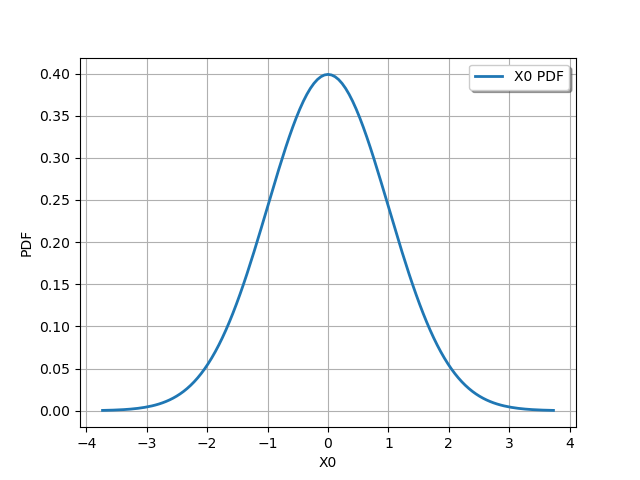

In [3]:
distribution.drawPDF()  # <-- This is the tested feature

### Using Matplotlib, if OpenTURNS had no drawPDF()

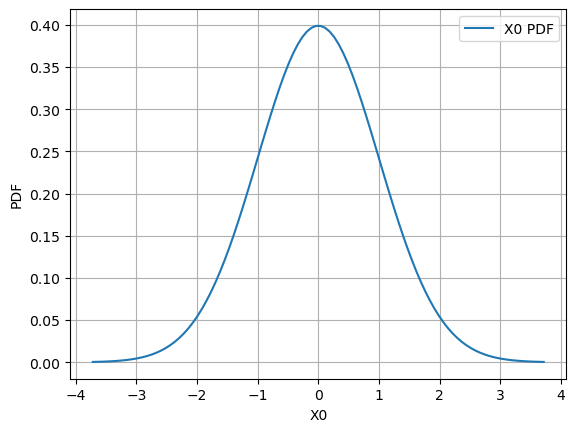

In [4]:
distribution = ot.Normal()
p = 1.0e-4
x_min = distribution.computeQuantile(p)
x_max = distribution.computeQuantile(p, True)
n_points = 100
x_values = np.linspace(x_min, x_max, n_points)
y_values = [distribution.computePDF(x) for x in x_values]
_ = pl.figure()
_ = pl.plot(x_values, y_values)
pl.xlabel("X0")
pl.ylabel("PDF")
pl.legend(["X0 PDF"])
pl.grid()

## Plot a (X, Y) sample from a function

### Using OpenTURNS only

We could use 
```python
from openturns.usecases import ishigami_function
im = ishigami_function.IshigamiModel()
```
but let us assume that we are interested in a brand new function.


In [5]:
def ishigami(x):
    x1, x2, x3 = x
    y = np.sin(x1) + 7.0 * np.sin(x2) ** 2 + 0.1 * x3**4 * np.sin(x1)
    return [y]


ishigami_g = ot.PythonFunction(3, 1, ishigami)
input_distribution = ot.JointDistribution([ot.Uniform(-np.pi, np.pi)] * 3)
input_sample = input_distribution.getSample(1000)
output_sample = ishigami_g(input_sample)

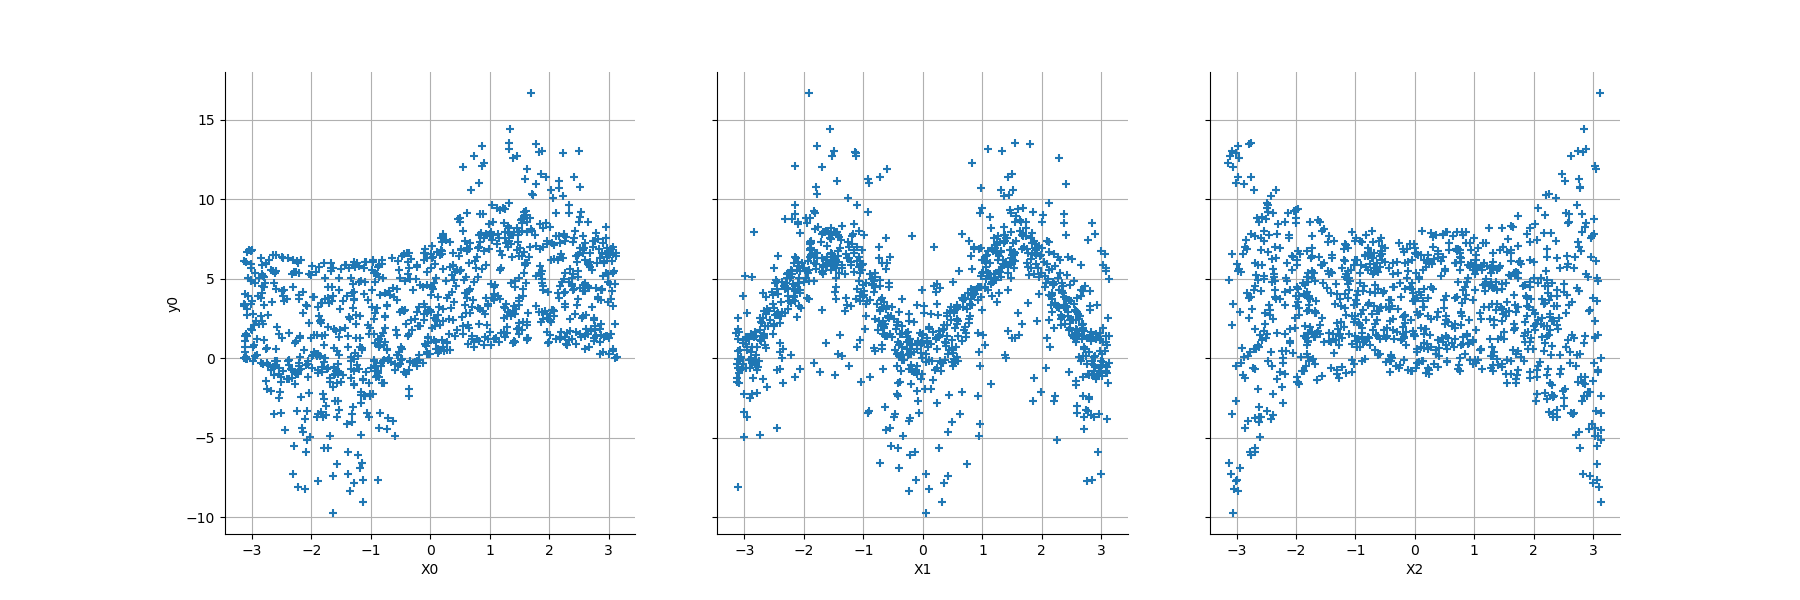

In [6]:
ot.VisualTest.DrawPairsXY(input_sample, output_sample)  # <-- This is the tested feature

### Using Matplotlib, if OpenTURNS had no DrawPairsXY()

Text(0, 0.5, 'y0')

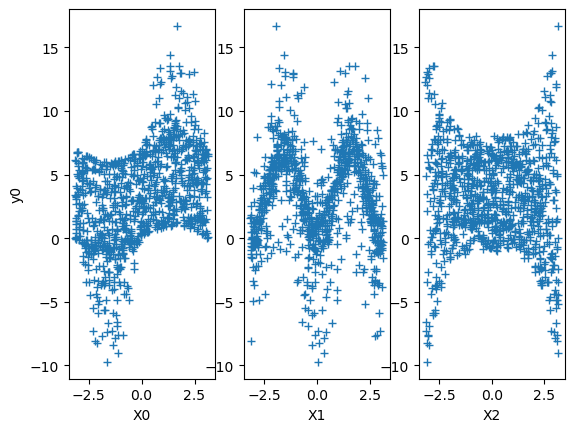

In [7]:
input_description = input_sample.getDescription()
output_description = output_sample.getDescription()
input_dimension = input_sample.getDimension()
_ = fig, axs = pl.subplots(1, input_dimension)
for i in range(input_dimension):
    _ = axs[i].plot(input_sample[:, i], output_sample[:, 0], "+")
    axs[i].set_xlabel(input_description[i])
axs[0].set_ylabel(output_description[0])

## Cross-cuts

### Using OpenTURNS only

In [8]:
m = WingWeightModel()
lowerBound = m.inputDistribution.getRange().getLowerBound()
upperBound = m.inputDistribution.getRange().getUpperBound()

nX = ot.ResourceMap.GetAsUnsignedInteger("Evaluation-DefaultPointNumber")
description = m.inputDistribution.getDescription()
description.add("")
m.model.setDescription(description)
m.model.setName("wing weight model")

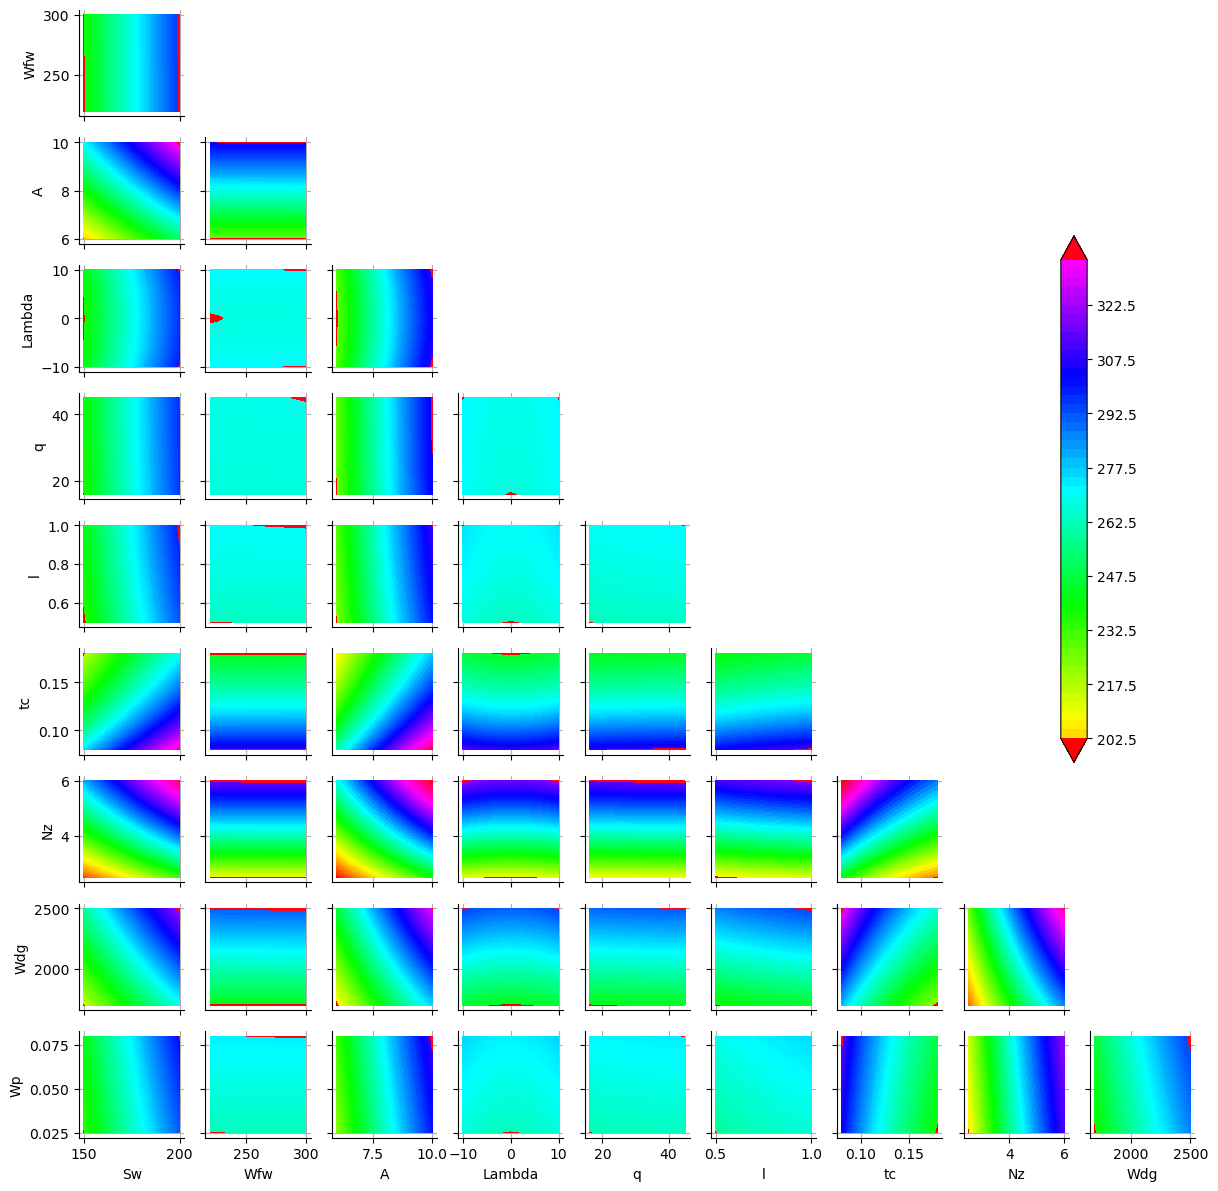

In [9]:
grid = m.model.drawCrossCuts(  # <-- This is the tested feature
    m.inputDistribution.getMean(),
    lowerBound,
    upperBound,
    [nX] * m.model.getInputDimension(),
    False,
    True,
    176.0,
    363.0,
)
grid.setTitle("")
# Get View object to manipulate the underlying figure
# Here we decide the colormap and the number of levels used for all contours
view = otv.View(grid, contour_kw={"cmap": "hsv", "levels": 55})

axes = view.getAxes()
fig = view.getFigure()
fig.set_size_inches(12, 12)  # reduce the size

# Setup a large colorbar
fig.colorbar(
    view.getSubviews()[1][0].getContourSets()[0], ax=axes[:-2, -1], fraction=0.3
)
# Hide unwanted axes labels
for i in range(len(axes)):
    for j in range(i + 1):
        if i < len(axes) - 1:
            axes[i][j].xaxis.set_ticklabels([])
        if j > 0:
            axes[i][j].yaxis.set_ticklabels([])
fig.subplots_adjust(top=0.99, bottom=0.05, left=0.06, right=0.99)

### Using Matplotlib, if OpenTURNS had no drawCrossCuts()

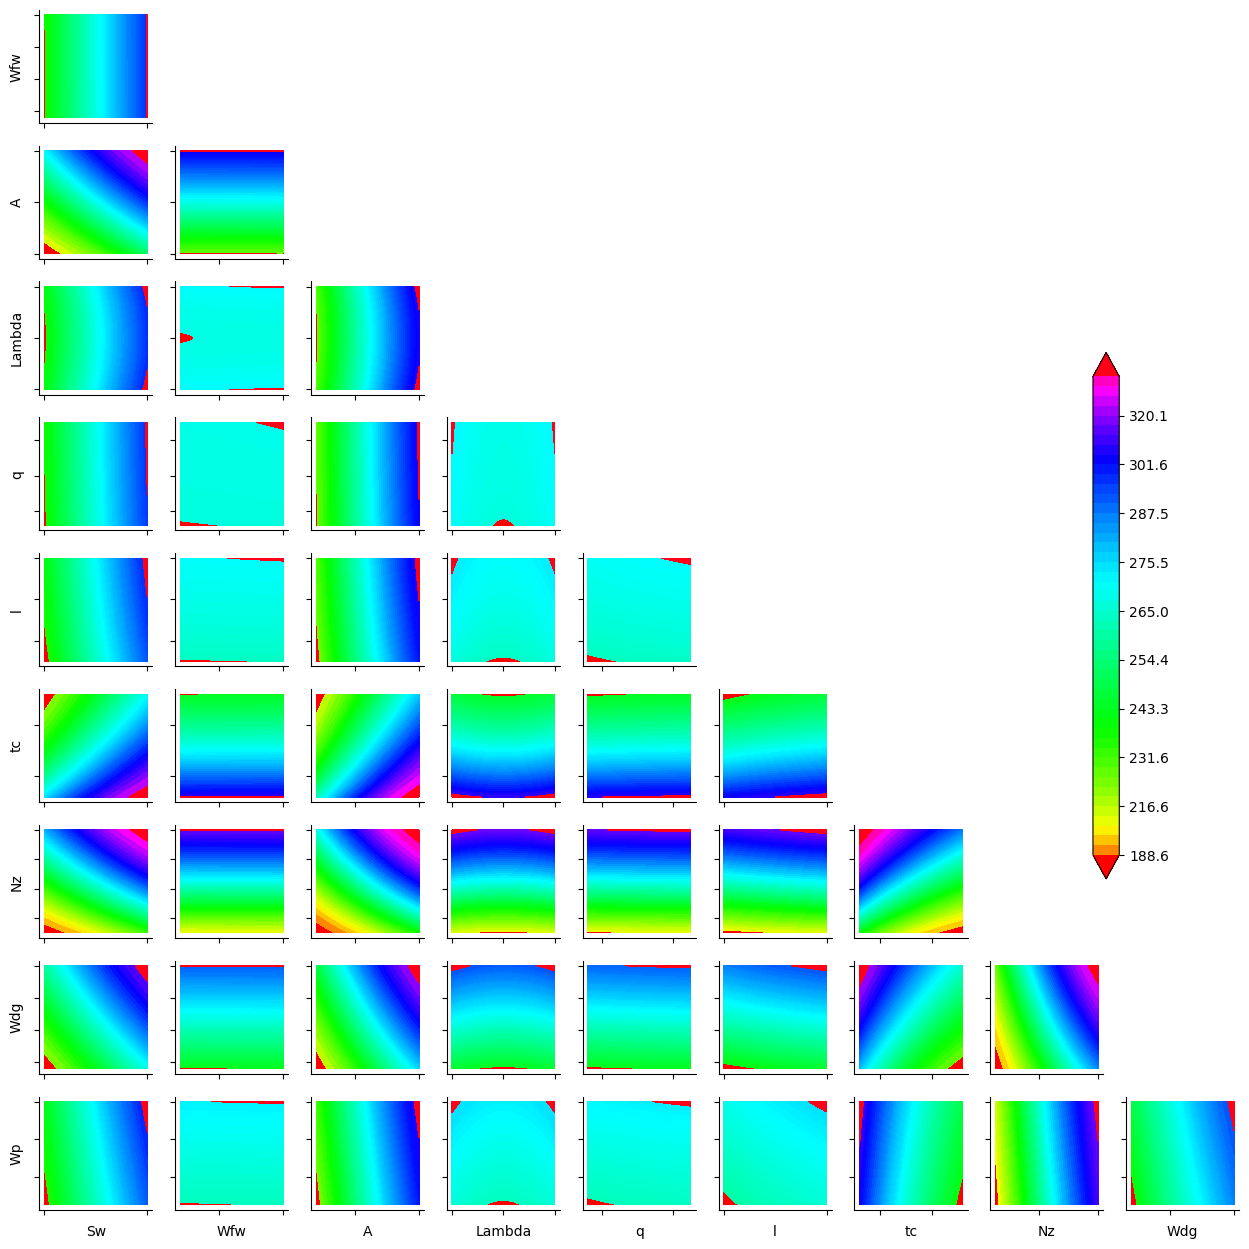

In [ ]:
ot.ResourceMap.SetAsBool("Contour-DefaultIsFilled", True)
ot.ResourceMap.SetAsUnsignedInteger("Contour-DefaultLevelsNumber", 50)

lowerBound = m.inputDistribution.getRange().getLowerBound()
upperBound = m.inputDistribution.getRange().getUpperBound()
input_distribution = m.inputDistribution

grid = ot.GridLayout(m.dim - 1, m.dim - 1)  # TODO: Fix this and use subplot
for i in range(1, m.dim):
    for j in range(i):
        crossCutIndices = []
        crossCutReferencePoint = []
        for k in range(m.dim):
            if k != i and k != j:
                crossCutIndices.append(k)
                # Definition of the reference point
                crossCutReferencePoint.append(input_distribution.getMean()[k])

        # Definition of 2D cross cut function
        crossCutFunction = ot.ParametricFunction(
            m.model, crossCutIndices, crossCutReferencePoint
        )
        crossCutLowerBound = [lowerBound[j], lowerBound[i]]
        crossCutUpperBound = [upperBound[j], upperBound[i]]

        # Get and customize the contour plot
        graph = crossCutFunction.draw(crossCutLowerBound, crossCutUpperBound)  # TODO: Fix this and use Matplotlib only
        graph.setTitle("")
        contour = graph.getDrawable(0).getImplementation()
        contour.setVmin(176.0)
        contour.setVmax(363.0)
        contour.setColorBarPosition("")  # suppress colorbar of each plot
        contour.setColorMap("hsv")
        graph.setDrawable(contour, 0)
        graph.setXTitle("")
        graph.setYTitle("")
        graph.setTickLocation(ot.GraphImplementation.TICKNONE)
        graph.setGrid(False)

        # Creation of axes title
        if j == 0:
            graph.setYTitle(input_distribution.getDescription()[i])
        if i == 9:
            graph.setXTitle(input_distribution.getDescription()[j])

        grid.setGraph(i - 1, j, graph)

# Get View object to manipulate the underlying figure
v = otv.View(grid)
fig = v.getFigure()
fig.set_size_inches(12, 12)  # reduce the size

# Setup a large colorbar
axes = v.getAxes()
colorbar = fig.colorbar(
    v.getSubviews()[6][2].getContourSets()[0], ax=axes[:, -1], fraction=0.3
)

fig.subplots_adjust(top=1.0, bottom=0.0, left=0.0, right=1.0)

## Contour

### Using OpenTURNS only

In [11]:
corr = ot.CorrelationMatrix(2)
corr[0, 1] = 0.2
copula = ot.NormalCopula(corr)
x1 = ot.Normal(-1.0, 1)
x2 = ot.Normal(2, 1)
x_funk = ot.JointDistribution([x1, x2], copula)

x1 = ot.Normal(1.0, 1)
x2 = ot.Normal(-2, 1)
x_punk = ot.JointDistribution([x1, x2], copula)
mixture = ot.Mixture([x_funk, x_punk], [0.5, 1.0])

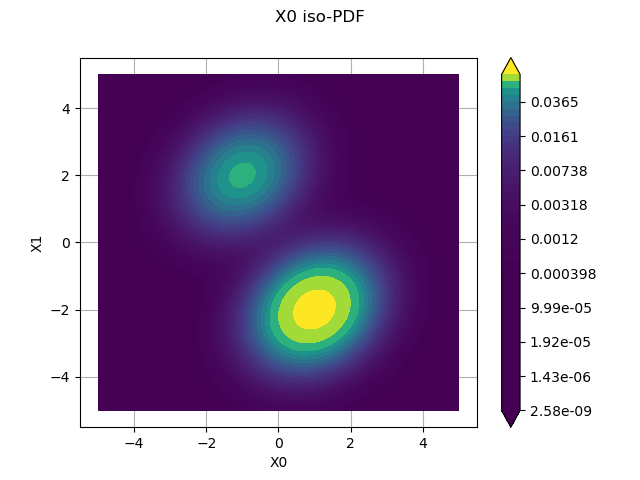

In [12]:
graph = mixture.drawPDF([-5.0, -5.0], [5.0, 5.0])  # <-- This is the tested feature
graph

### Using Matplotlib, if OpenTURNS had no drawPDF()

<Figure size 640x480 with 0 Axes>

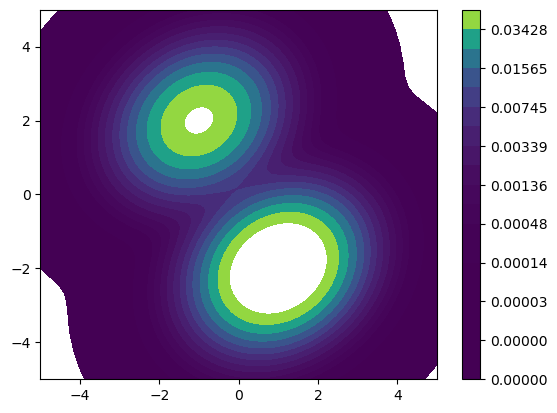

In [13]:
# Create the input mesh
lowerBound = [-5.0, -5.0]
upperBound = [5.0, 5.0]
numberOfXCells = 100
numberOfYCells = 100
xList = np.linspace(lowerBound[0], upperBound[0], numberOfXCells)
yList = np.linspace(lowerBound[1], upperBound[1], numberOfYCells)
xArray, yArray = np.meshgrid(xList, yList)
# Convert to Sample
xArrayFlat = xArray.flatten()
yArrayFlat = yArray.flatten()
size = numberOfXCells * numberOfYCells
inputSample = ot.Sample(size, 2)
inputSample[:, 0] = ot.Sample.BuildFromPoint(xArrayFlat)
inputSample[:, 1] = ot.Sample.BuildFromPoint(yArrayFlat)
# Evaluate the function
zArray = mixture.computePDF(inputSample)
zArray = np.array(zArray)
zArray = zArray.transpose()
zArray = np.reshape(zArray, (numberOfYCells, numberOfXCells))
# Compute levels
epsilonGrid = 5.0e-2
numberOfLevels = 20
zSample = ot.Sample.BuildFromPoint(zArray.flatten())
regularGrid = np.linspace(epsilonGrid, 1.0 - epsilonGrid, numberOfLevels)
levelsSample = zSample.computeQuantile(regularGrid)
levels = [point[0] for point in levelsSample]
# Plot with customized levels
_ = pl.figure()
fig, ax = pl.subplots(1, 1)
cp = ax.contourf(xArray, yArray, zArray, levels, cmap=mpl.cm.viridis)
_ = fig.colorbar(cp)
# TODO: find the exact same visual result

## Sobol' indices

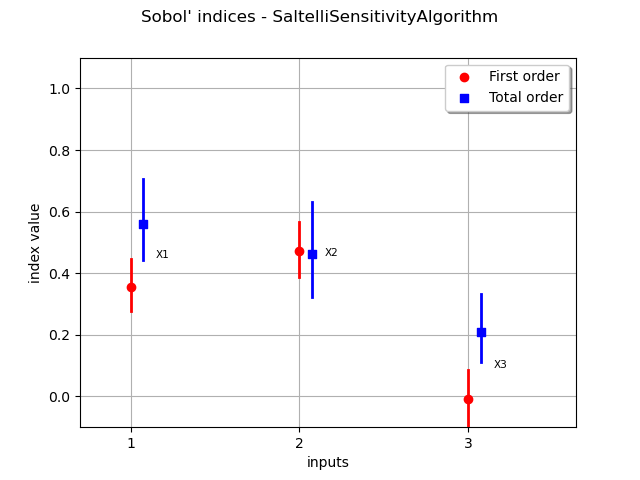

In [14]:
im = ishigami_function.IshigamiModel()
input_names = im.inputDistribution.getDescription()
size = 1000
sie = ot.SobolIndicesExperiment(im.inputDistribution, size)
inputDesign = sie.generate()
input_names = im.inputDistribution.getDescription()
inputDesign.setDescription(input_names)
inputDesign.getSize()
outputDesign = im.model(inputDesign)
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)
graph = sensitivityAnalysis.draw()
graph

### Using Matplotlib, if OpenTURNS had no draw()

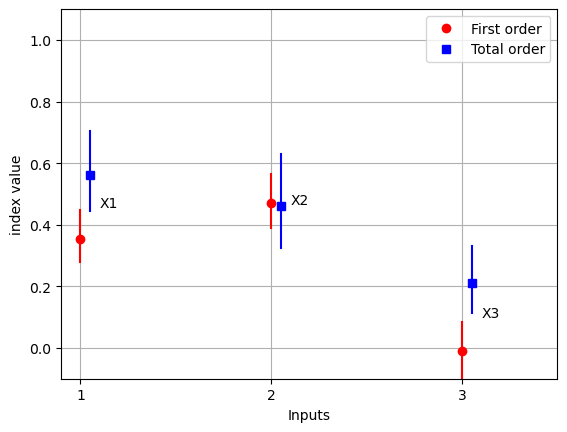

In [16]:
first_order_indices = sensitivityAnalysis.getFirstOrderIndices()
total_order_indices = sensitivityAnalysis.getTotalOrderIndices()
input_dimension = im.inputDistribution.getDimension()
fig = pl.figure()
input_indices = range(1, 1 + input_dimension)
pl.plot(input_indices, first_order_indices, "ro", label="First order")
delta_x = 0.05
shifted_indices = [1 + i + delta_x for i in range(input_dimension)]
pl.plot(shifted_indices, total_order_indices, "bs", label="Total order")
pl.legend()
pl.ylim(-0.1, 1.1)
pl.grid()
ax = pl.gca()  # Get the current axes
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
pl.xlabel("Inputs")
confidenceLevel = 0.95
first_order_distribution = sensitivityAnalysis.getFirstOrderIndicesDistribution()
total_order_distribution = sensitivityAnalysis.getTotalOrderIndicesDistribution()
description = im.inputDistribution.getDescription()
for i in range(input_dimension):
    # First order
    marginal_first_order_distribution = first_order_distribution.getMarginal(i)
    marginal_interval = (
        marginal_first_order_distribution.computeBilateralConfidenceInterval(
            confidenceLevel
        )
    )
    first_order_lower_bound = marginal_interval.getLowerBound()[0]
    first_order_uper_bound = marginal_interval.getUpperBound()[0]
    pl.plot([1 + i, 1 + i], [first_order_lower_bound, first_order_uper_bound], "r-")
    # Total order
    marginal_total_order_distribution = total_order_distribution.getMarginal(i)
    marginal_interval = (
        marginal_total_order_distribution.computeBilateralConfidenceInterval(
            confidenceLevel
        )
    )
    total_order_lower_bound = marginal_interval.getLowerBound()[0]
    total_order_uper_bound = marginal_interval.getUpperBound()[0]
    pl.plot(
        [1 + i + delta_x, 1 + i + delta_x],
        [total_order_lower_bound, total_order_uper_bound],
        "b-",
    )
    # Label
    vertical_location = 0.5 * (first_order_indices[i] + total_order_indices[i])
    pl.text(1 + i + 2 * delta_x, vertical_location, description[i])
_ = pl.ylabel("index value")
_ = pl.xlim(0.9, input_dimension + 0.5)